# Purpose:
This notebook will show the creation of Figure 4 of the Paper

Import Modules

In [15]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv
import pylab
pylab.rcParams['figure.figsize'] = (35.0, 8.0) #makes figure size wider
import datetime
from math import radians, cos, sin, asin, sqrt
import math
import time
import scipy.io as sio
from TPtrip import *
from fuel_calc import *
import cPickle as pickle

## Figure A: Distribution of Trip Distances in time 1 (8 - 9 AM)

In [2]:
# Load the All trips filtered pickle to extract the appropriate TripTable entries 

t = time.time()
Alltrips_staysremoved = pickle.load( open( "data/Alltrips_Github.pkl", "rb" ) )
elapsed = time.time() - t
print 'Performed in', elapsed, 'sec'

Performed in 296.466650009 sec


In [3]:
# Load Segments_byEdge time 1 for matched segments (for free flow speed from edges)

segments_byEdge_time1 = pickle.load(open('data/matchedSegmentsbyEdge_time1_8_9AM_weekdays_github.pkl', 'r'))

In [4]:
# Load streets network with FC Estimates filled 
with  open( "data/Riyadh_streets_FC_Figure3_alltimes.pkl", "rb" ) as i:
    
    streets =  pickle.load(i )

In [5]:
# Extract list of edges (order unimportant, repetition not allowed) for each trip
# inherent assumption: route traverses an edge only once.
matchedtrips_time1 = {}
for edge in segments_byEdge_time1:
    for trip in segments_byEdge_time1[edge]:
        if not( trip in matchedtrips_time1):
            matchedtrips_time1[trip] = [edge]
        else: 
            matchedtrips_time1[trip].append(edge)

# build a dictionary of tripID to index for the list Alltrips_staysremoved
tripids = {}
for i in range(len(Alltrips_staysremoved)):
    
    tripids[Alltrips_staysremoved[i].TripID]=i 


In [6]:
# filter for time1 trips taking into account GMT time

timeWindow = [8,9]
time1 = True
starttime = datetime.time(timeWindow[0]-3,0,0)
endtime = datetime.time(timeWindow[1]-3,0,0)
weekdays = [1,2,3,4,7] # weekdays in isoweekday datetime format

Time1Trips = []
for i in range(len(Alltrips_staysremoved)):
    if (starttime <= Alltrips_staysremoved[i].PickUp_Time.time() <= endtime) and Alltrips_staysremoved[i].PickUp_Time.isoweekday() in weekdays:
        Time1Trips.append(Alltrips_staysremoved[i]) # this also removes the list is lists to make it a list of TP_trip instances directly
        
trip_dist_fromgps = []
dist_time1_b = []
for trip in matchedtrips_time1:
    index = tripids[trip]
    sumdist = [Alltrips_staysremoved[index].TripTable[i][4] for i in range(len(Alltrips_staysremoved[index].TripTable))]
    sumdist = np.sum(sumdist)
    trip_dist_fromgps.append(sumdist)
    dist_time1_b.append(float(Alltrips_staysremoved[index].Distance_KM))
    

In [7]:
# Build a dict between edge nodes and GID:
gid_2_edge = {}
for n1,n2 in streets.edges():

    gid_2_edge[streets[n1][n2]['gid']] = (n1, n2)

In [8]:
# build a dictionary of tripID to index for the list Alltrips_staysremoved
tripids = {}
for i in range(len(Alltrips_staysremoved)):
    
    tripids[Alltrips_staysremoved[i].TripID]=i 

In [9]:
# Extract Free flow time for each segment, sum them for each trip and save to dict

trip_ff_totaltime = {}
for trip in matchedtrips_time1:
    for edge in matchedtrips_time1[trip]:
        e1,e2 = gid_2_edge[edge]
        fftime = streets[e1][e2]['cost_time_m']
        if not(trip in trip_ff_totaltime): 
            trip_ff_totaltime[trip] = fftime
        else: 
            trip_ff_totaltime[trip] += fftime


In [10]:
# List of Observed trip durations for trips with matched segments
trip_obs_durations_time1 = {}
for key in trip_ff_totaltime:
    index = tripids[key]
    duration = Alltrips_staysremoved[index].Dropoff_Time - Alltrips_staysremoved[index].PickUp_Time
    trip_obs_durations_time1[key]= duration.seconds/60.

ff_TT_time1 = [val for key, val in trip_ff_totaltime.iteritems()]
cong_TT_time1 = [val for key, val in trip_obs_durations_time1.iteritems()]

In [11]:

# create a dict of Fuel consumption of matched trips using constant speed (Streestmart model with 0 acc)
FC_constantspeed = []
FE_constantspeed = []
FC_constantspeed_Rprop = []
FE_constantspeed_Rprop = []
for trip in matchedtrips_time1:
    tm = float((Alltrips_staysremoved[tripids[trip]].Dropoff_Time - Alltrips_staysremoved[tripids[trip]].PickUp_Time).seconds)
    ivdt = float(Alltrips_staysremoved[tripids[trip]].Distance_KM)
    fuel_gal = Fuelconsump_Riyadhbin(0,tm,0,ivdt,bin_num=[8])
    fuel_gal_Rprop = Fuelconsump_Riyadhbin(0,tm,0,ivdt, range(14))
    FC_constantspeed.append(fuel_gal)
    FC_constantspeed_Rprop.append(fuel_gal_Rprop)
    MPG = (float(Alltrips_staysremoved[tripids[trip]].Distance_KM)*0.621371)/fuel_gal
    MPG_Rprop = (float(Alltrips_staysremoved[tripids[trip]].Distance_KM)*0.621371)/fuel_gal_Rprop
    FE_constantspeed.append(MPG)
    FE_constantspeed_Rprop.append(MPG_Rprop)

In [20]:

# Create a dict with keys the tripID and the values another dic with keys the GPS index and value the triptable list index
# This is mainly for the trips that have been split around stays (~1400 trips) which have TripTable indices different from GPS indices
GPSi_2_TripTablei = {}
for i in range(len(Alltrips_staysremoved)):
    GPSi_2_TripTablei[Alltrips_staysremoved[i].TripID] = {}
    for u in range(len(Alltrips_staysremoved[i].TripTable)):
        GPS_index = Alltrips_staysremoved[i].TripTable[u][0]
        GPSi_2_TripTablei[Alltrips_staysremoved[i].TripID][GPS_index] = u


In [46]:

def computemetrics(segments, tripid):
    """
    Computing metrics of a given set of Triptable entries:
    function that takes list of triptable segments and returns metrics
    """

    ti = 0
    tm = 0
    ivdt = 0
    iadx=0
    index = tripids[tripid]
    for seg in segments:
        table_i = GPSi_2_TripTablei[tripid][seg[0]]
        time = seg[3]
        simple_dist = seg[4]
        speed = seg[5]
        acc = seg[6]
        if speed == 0: ti = ti + time
        else: tm = tm + time
        ivdt = ivdt + simple_dist
        #calculates avg_dist covered around a single GPS point as the average of the distances of the segements including that point.
        avg_dist = 0.5*(simple_dist+Alltrips_staysremoved[index].TripTable[table_i-1][4])*1000 # converts from km to m
        iadx = iadx + abs(acc*avg_dist)
    return [ti,tm,iadx,ivdt]


In [50]:
# creates a dict of FC of matched trips using speed profiles

FC_speedprofiles = []
FE_speedprofiles = []
for trip in matchedtrips_time1:
    index = tripids[trip]
    segments = [Alltrips_staysremoved[index].TripTable[i] for i in range(len(Alltrips_staysremoved[index].TripTable))]
    ti=0;tm=0;iadx=0;ivdt=0
    ti, tm, iadx, ivdt = computemetrics(segments, trip)
    fuel_gal = Fuelconsump_Riyadhbin(ti, tm, iadx, ivdt, bin_num=[8])
    FC_speedprofiles.append(fuel_gal)
    MPG = (float(Alltrips_staysremoved[index].Distance_KM)*0.621371)/fuel_gal
    FE_speedprofiles.append(MPG)



In [59]:
# FC and FE with speed profiles and using all bins in Riyadh Fleet proportions
FC_speedprofiles_Rprop = []
FE_speedprofiles_Rprop = []
for trip in matchedtrips_time1:
    index = tripids[trip]
    segments = [Alltrips_staysremoved[index].TripTable[i] for i in range(len(Alltrips_staysremoved[index].TripTable))]
    ti=0;tm=0;iadx=0;ivdt=0
    ti, tm, iadx, ivdt = computemetrics(segments, trip)
    fuel_gal = Fuelconsump_Riyadhbin(ti, tm, iadx, ivdt, range(14))
    FC_speedprofiles_Rprop.append(fuel_gal)
    MPG = (float(Alltrips_staysremoved[index].Distance_KM)*0.621371)/fuel_gal # converts [km] to [mi] and FC to FE
    FE_speedprofiles_Rprop.append(MPG)

In [92]:
# create a dict of Fuel consumption of matched trips using constant speed
FC_constantspeed = []
FE_constantspeed = []
FC_constantspeed_Rprop = []
FE_constantspeed_Rprop = []
IVDTS = []
times = []
for trip in matchedtrips_time1:
    
    duration = Alltrips_staysremoved[tripids[trip]].Dropoff_Time - Alltrips_staysremoved[tripids[trip]].PickUp_Time

    tm = float(duration.seconds)
    ivdt = float(Alltrips_staysremoved[tripids[trip]].Distance_KM)
    fuel_gal = Fuelconsump_Riyadhbin(0,tm,0,ivdt,bin_num=[8])
    fuel_gal_Rprop = Fuelconsump_Riyadhbin(0,tm,0,ivdt, range(14))
    FC_constantspeed.append(fuel_gal)
    FC_constantspeed_Rprop.append(fuel_gal_Rprop)
    MPG = (float(Alltrips_staysremoved[tripids[trip]].Distance_KM)*0.621371)/fuel_gal
    MPG_Rprop = (float(Alltrips_staysremoved[tripids[trip]].Distance_KM)*0.621371)/fuel_gal_Rprop
    FE_constantspeed.append(MPG)
    FE_constantspeed_Rprop.append(MPG_Rprop)
    IVDTS.append(ivdt)
    times.append(tm)
    


In [94]:
# Covnert units from US galons to Liters
FC_constantspeed_metric = np.multiply(FC_constantspeed, 3.78541)
FC_speedprofles_metric = np.multiply(FC_speedprofiles, 3.78541)
# Convert FE from MPG to KM/l
FE_speedprofiles_metric= np.multiply(FE_speedprofiles,0.4251437075)
FE_constantspeed_metric= np.multiply(FE_constantspeed, 0.4251437075)
FE_speedprofiles_Rprop_metric= np.multiply(FE_speedprofiles_Rprop,0.4251437075)
FE_constantspeed_Rprop_metric= np.multiply(FE_constantspeed_Rprop,0.4251437075)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


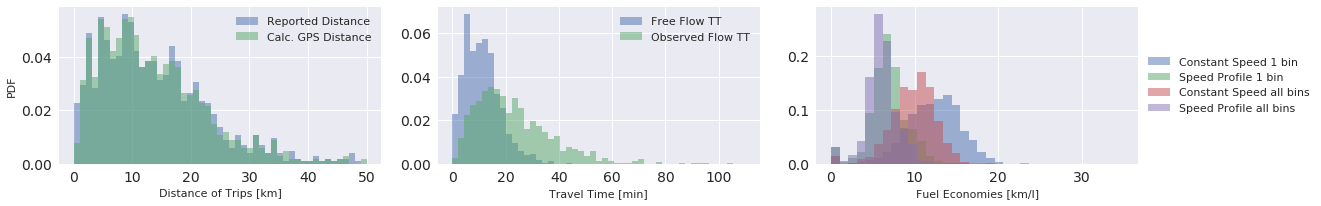

In [95]:
# Putting all A B C figures into one and saving as eps

plt.clf
plt.close()

fig, ax = plt.subplots(1,3, figsize =(16,3)) # one row, 3 columns
plt.tight_layout()
font = {'family' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('legend',**{'fontsize':11})

bins0 = np.linspace(0, 50, 50)
ax[0].hist(dist_time1_b,bins0 , normed=1,  alpha = 0.5, label = 'Reported Distance')
ax[0].hold(True)
ax[0].hist(trip_dist_fromgps, bins0, normed = 1, alpha = 0.5, label = 'Calc. GPS Distance')
ax[0].set_ylabel('PDF')
ax[0].set_xlabel('Distance of Trips [km]')
ax[0].legend(loc = 'upper right')

bins1 = np.linspace(0, 110, 50)
ax[1].hist(ff_TT_time1, bins1,normed=True,alpha = 0.5, label = 'Free Flow TT')
ax[1].hold(True)
ax[1].hist(cong_TT_time1, bins1,normed=True,alpha = 0.5, label = 'Observed Flow TT')
ax[1].set_xlabel('Travel Time [min]')
ax[1].legend(loc = 'upper right')

bins2 = np.linspace(0,35, 35)
ax[2].hist(FE_constantspeed_metric,bins2,normed=True,alpha = 0.5, label = 'Constant Speed 1 bin')
ax[2].hold(True)
ax[2].hist(FE_speedprofiles_metric,bins2, normed=True,alpha = 0.5, label = 'Speed Profile 1 bin')
plt.hist(FE_constantspeed_Rprop_metric,bins2, normed=True,alpha = 0.5, label = 'Constant Speed all bins')
ax[2].hist(FE_speedprofiles_Rprop_metric,bins2, normed=True,alpha = 0.5, label = 'Speed Profile all bins')
ax[2].set_xlabel('Fuel Economies [km/l]')
# ax[2].set_xlim([0,25])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc = 'upper right')


plt.show()
# plt.savefig('Figure_Verification_onerow_1_metric_new.eps', bbox_inches = 'tight', dpi = 300)